Carregando o extrator de características do TensorFlow Hub...
Modelo carregado com sucesso!

Extraindo características de 400 imagens...
Extração de características concluída!

Construindo o índice Annoy...
Índice Annoy construído e salvo!

Realizando busca com a imagem: ./meus_produtos/notebook/notebook_001.jpg


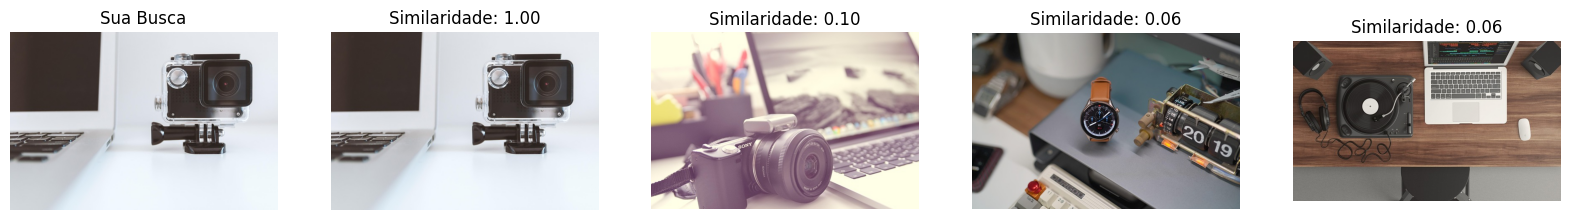

In [7]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from annoy import AnnoyIndex
from PIL import Image
import matplotlib.pyplot as plt
import glob

# --- PASSO 1: PREPARAÇÃO (Mesmo de antes) ---
# Garanta que suas imagens estão na pasta correta.
# Exemplo: !unzip -q meus_produtos.zip
data_dir = './meus_produtos/'

# --- PASSO 2: EXTRAÇÃO DE CARACTERÍSTICAS (NOVA ABORDAGEM DIRETA) ---

IMAGE_SIZE = (224, 224)
# Usaremos uma URL estável do TensorFlow Hub. [3]
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# --- INÍCIO DA CORREÇÃO ---
# Carregamos o modelo diretamente do Hub como uma função pronta para uso.
# Não usamos mais tf.keras.Model, tf.keras.Input ou hub.KerasLayer.
print("Carregando o extrator de características do TensorFlow Hub...")
feature_extractor = hub.load(feature_extractor_url)
print("Modelo carregado com sucesso!")
# --- FIM DA CORREÇÃO ---

# Função para pré-processar uma imagem
def preprocess_image(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = img / 255.0  # Normalizar pixels para o intervalo [0, 1]
        return tf.expand_dims(img, axis=0) # Adicionar a dimensão do batch
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

# Lista de imagens e mapeamentos
image_paths = [path for path in glob.glob(os.path.join(data_dir, '**', '*.jpg'), recursive=True)]
image_paths.sort()
index_to_path = {i: path for i, path in enumerate(image_paths)}
image_vectors = {}

print(f"\nExtraindo características de {len(image_paths)} imagens...")
for i, path in enumerate(image_paths):
    processed_img = preprocess_image(path)
    if processed_img is not None:
        # Chamamos o extrator diretamente, como uma função
        vector = feature_extractor(processed_img) # Isso retorna um Tensor do TensorFlow
        # Convertemos o Tensor para um array NumPy e o achatamos
        image_vectors[i] = vector.numpy().flatten()

print("Extração de características concluída!")

# --- PASSO 3: INDEXAÇÃO COM ANNOY (sem alterações) ---

vector_dim = 1280 # Dimensão do vetor do MobileNetV2
annoy_index = AnnoyIndex(vector_dim, 'angular')

print("\nConstruindo o índice Annoy...")
for i, vector in image_vectors.items():
    annoy_index.add_item(i, vector)

annoy_index.build(10) # 10 árvores de busca
annoy_index.save('product_index.ann')
print("Índice Annoy construído e salvo!")


# --- PASSO 4: REALIZANDO UMA RECOMENDAÇÃO ---

def find_similar_images(query_path, num_results=5):
    processed_query = preprocess_image(query_path)
    if processed_query is None:
        print("Não foi possível processar a imagem de busca.")
        return

    # Usamos o mesmo extrator para a imagem de busca
    query_vector = feature_extractor(processed_query).numpy().flatten()

    indices, distances = annoy_index.get_nns_by_vector(query_vector, num_results, include_distances=True)

    # Exibição dos resultados
    plt.figure(figsize=(20, 10))
    plt.subplot(1, num_results + 1, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Sua Busca")
    plt.axis('off')

    for i, idx in enumerate(indices):
        img_path = index_to_path[idx]
        plt.subplot(1, num_results + 1, i + 2)
        plt.imshow(Image.open(img_path))
        plt.title(f"Similaridade: {1-distances[i]:.2f}")
        plt.axis('off')

    plt.show()

# --- TESTE FINAL ---
if image_paths:
    test_index = min(len(image_paths) - 1, 0) # Pega a primeira imagem para teste
    caminho_da_sua_imagem_de_teste = image_paths[test_index]
    print(f"\nRealizando busca com a imagem: {caminho_da_sua_imagem_de_teste}")
    find_similar_images(caminho_da_sua_imagem_de_teste, num_results=4)
else:
    print("\nNenhuma imagem encontrada. Verifique se o caminho da pasta está correto.")